In [1]:
import numpy as np

In [2]:
import keras

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras import Model

In [5]:
from tensorflow.keras.layers import Input,Embedding,Dense,Dropout,LayerNormalization

In [248]:
class LayerNormalization1(tf.keras.layers.Layer):
    def __init__(self, parameter_shape, eps=1e-5):
        super(LayerNormalization1, self).__init__()
        self.parameter_shape = parameter_shape
        self.eps = eps
        self.gamma = tf.Variable(tf.ones(parameter_shape), trainable=True)
        self.beta = tf.Variable(tf.zeros(parameter_shape), trainable=True)
        
    def call(self, inputs):
        mean = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        var = tf.reduce_mean(tf.square(inputs - mean), axis=-1, keepdims=True)
        std = tf.sqrt(var + self.eps)
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        return out

In [350]:
def scaled_dot_product(q,k,v,mask=None):
    scale=q.shape[-1]
    k=tf.transpose(k,perm=(0,1,3,2))
    scaled=tf.matmul(q,k)/np.sqrt(scale)
    if mask is not None:
        scaled+=mask
    attention_wts=tf.nn.softmax(scaled,axis=-1)
    values=tf.matmul(scaled,v)
    return values,attention_wts

In [351]:
class MultiHead_Attention(tf.keras.layers.Layer):
    def __init__(self,no_of_heads,d_model):
        super(MultiHead_Attention,self).__init__()
        self.n_heads=no_of_heads
        self.head_dims=d_model//no_of_heads
        self.qkv=Dense(3*d_model)
        self.dense=Dense(d_model)
        
    def call(self,inputs,mask=None):
        batch_size,max_inp_len,d_model=inputs.shape
        qkv=self.qkv(inputs)
        desired_shape = (batch_size, max_inp_len, self.n_heads, 3 * self.head_dims)
        qkv=tf.reshape(qkv,desired_shape)
        qkv=tf.transpose(qkv,perm=(0,2,1,3))
        q,k,v=tf.split(qkv,num_or_size_splits=3,axis=3)
        v,attention_wts=scaled_dot_product(q,k,v)
        v=tf.reshape(v,(batch_size,max_inp_len,self.n_heads*self.head_dims))
        output=self.dense(v)
        return output

In [352]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self,d_model,ffc,dropout):
        super(FeedForward,self).__init__()
        self.dense1=Dense(ffc,activation="relu")
        self.dense2=Dense(d_model)
        self.dropout=Dropout(rate=dropout)
        
    def call(self,inputs,training=False):
        if training==True:
            print("Feed_forward:",True)
        x=self.dense1(inputs)
        x=self.dropout(x,training=training)
        x=self.dense2(x)
        return x

In [353]:
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, parameter_shape, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.parameter_shape = parameter_shape
        self.eps = eps
        self.gamma = self.add_weight("gamma", shape=parameter_shape, initializer="ones", trainable=True)
        self.beta = self.add_weight("beta", shape=parameter_shape, initializer="zeros", trainable=True)
        
    def call(self, inputs):
        mean = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        var = tf.reduce_mean(tf.square(inputs - mean), axis=-1, keepdims=True)
        std = tf.sqrt(var + self.eps)
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        return out


In [354]:
class Encoder_Layer(tf.keras.layers.Layer):
    def __init__(self,num_of_heads,d_model,dff,dropout):
        super(Encoder_Layer,self).__init__()
        self.mha=MultiHead_Attention(num_of_heads,d_model)
        self.dropout1=Dropout(rate=dropout)
        self.ln1=LayerNormalization(d_model)
        self.ff=FeedForward(d_model,dff,dropout)
        self.dropout2=Dropout(rate=dropout)
        self.ln2=LayerNormalization(d_model)
        
    def call(self,inputs,mask,training=False):
        if training==True:
            print("Encoder_Layer:",True)
        mha_output=self.mha(inputs,mask)
        output_dropout1=self.dropout1(mha_output,training=training)
        ln1_output=self.ln1(output_dropout1+inputs)
        
        ffn_output=self.ff(ln1_output,training)
        ffn_output_dropout=self.dropout2(ffn_output,training=training)
        ln2_output=self.ln2(ffn_output_dropout+ln1_output)
        return ln2_output

In [355]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,num_of_heads,d_model,dff,dropout,num_layers):
        super(Encoder,self).__init__()
        self.encoder_layer=[Encoder_Layer(n,d_model,ffc,dropout) for _ in range(num_layers)]
        
    def call(self,inputs,mask=False,training=False):
        if training==True:
            print("Encoder:",True)
        x=inputs
        for layer in self.encoder_layer:
            x=layer(x,mask,training)
        return x

In [356]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,n_layers,d_model,dropout,no_heads,dff):
        super(Decoder,self).__init__()
        self.decoder_layers=[Decoder_Layer(d_model,dropout,no_heads,dff) for _ in range(n_layers)]
        
    def call(self,x,y,look_ahead_mask=None,padding_mask=None,training=False):
        if training==True:
            print("Decoder:",True)
        for layer in self.decoder_layers:
            y=layer(x,y,look_ahead_mask,padding_mask,training)
        return y         

In [357]:
class Decoder_Layer(tf.keras.layers.Layer):
    def __init__(self,d_model,dropout,no_heads,dff):
        super(Decoder_Layer,self).__init__()
        self.mha=MaskedMultiHead_Attention(no_heads,d_model)
        self.dropout1=Dropout(rate=dropout)
        self.norm1=LayerNormalization(d_model)
        
        self.mhca=MultiHeadCross_Attention(no_heads,d_model)
        self.dropout2=Dropout(rate=dropout)
        self.norm2=LayerNormalization(d_model)
        
        self.ff=FeedForward(d_model,dff,dropout)
        self.dropout3=Dropout(rate=dropout)
        self.norm3=LayerNormalization(d_model)
        
    def call(self,x,y,look_ahead_mask,padding_mask,training=False):
        if training==True:
            print("Decoder_Layer:",True)
        mha_output=self.mha(y,mask=look_ahead_mask)
        mha_output_dropout=self.dropout1(mha_output,training=training)
        norm1_output=self.norm1(mha_output_dropout+y)
        
        cmha_output=self.mhca(x,norm1_output,mask=padding_mask)
        cmha_output_dropout=self.dropout2(cmha_output,training=training)
        norm2_output=self.norm2(cmha_output_dropout+norm1_output)
        
        ff_output=self.ff(norm2_output,training)
        ff_output_dropout=self.dropout3(ff_output,training=training)
        norm3_output=self.norm3(ff_output_dropout+norm2_output)
        return norm3_output

In [358]:
class MaskedMultiHead_Attention(tf.keras.layers.Layer):
    def __init__(self,no_of_heads,d_model):
        super(MaskedMultiHead_Attention,self).__init__()
        self.n_heads=no_of_heads
        self.head_dims=d_model//no_of_heads
        self.qkv=Dense(3*d_model)
        self.dense=Dense(d_model)
        
    def call(self,inputs,mask=None):
        batch_size,max_inp_len,d_model=inputs.shape
        qkv=self.qkv(inputs)
        desired_shape = (batch_size, max_inp_len, self.n_heads, 3 * self.head_dims)
        qkv=tf.reshape(qkv,desired_shape)
        qkv=tf.transpose(qkv,perm=(0,2,1,3))
        q,k,v=tf.split(qkv,num_or_size_splits=3,axis=3)
        v,attention_wts=scaled_dot_product(q,k,v,mask)
        v=tf.reshape(v,(batch_size,max_inp_len,self.n_heads*self.head_dims))
        output=self.dense(v)
        return output

In [359]:
class MultiHeadCross_Attention(tf.keras.layers.Layer):
    def __init__(self,no_of_heads,d_model):
        super(MultiHeadCross_Attention,self).__init__()
        self.n_heads=no_of_heads
        self.head_dims=d_model//no_of_heads
        self.kv=Dense(2*d_model)
        self.q=Dense(d_model)
        self.dense=Dense(d_model)
        
    def call(self,x,y,mask=None):
        batch_size,max_inp_len,d_model=x.shape
        batch_size,max_tar_len,d_model=y.shape
        kv=self.kv(x)
        q=self.q(y)
        kv=tf.reshape(kv,(batch_size, max_inp_len, self.n_heads, 2 * self.head_dims))
        q=tf.reshape(q,(batch_size, max_tar_len, self.n_heads, self.head_dims))
        kv=tf.transpose(kv,perm=(0,2,1,3))
        q=tf.transpose(q,perm=(0,2,1,3))
        k,v=tf.split(kv,num_or_size_splits=2,axis=3)
        v,attention_wts=scaled_dot_product(q,k,v,mask)
        v=tf.reshape(v,(batch_size,max_tar_len,d_model))
        output=self.dense(v)
        return output

In [406]:
class Transformer(tf.keras.Model):
    def __init__(self,n_layers,dropout,dff,n_heads,d_model):
        super(Transformer,self).__init__()
        self.encoder=Encoder(n_heads,d_model,dff,dropout,n_layers)
        self.decoder=Decoder(n_layers,d_model,dropout,n_heads,dff)
        
    def create_padding_mask(self,seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:,tf.newaxis,tf.newaxis,:]
    
    def create_look_ahead_mask(self,size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask
    
    def create_masks(inputs, target):
        enc_padding_mask = create_padding_mask(inputs)
        dec_padding_mask = create_padding_mask(target)
        look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
        dec_target_padding_mask = create_padding_mask(target)

        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, combined_mask, dec_padding_mask
    
    def call(self,inputs,training=False):
        x,y=inputs
        enc_padding_mask,look_ahead_mask,dec_padding_mask=create_masks(x,y)
        
        encoder_op=self.encoder(x,mask=enc_padding_mask,training=training)
        decoder_op=self.decoder(encoder_op,y,look_ahead_mask=dec_in_lookahead_mask,
                            padding_mask=dec_in_padding_mask,training=training)
        return decoder_op

In [407]:
transformer=Transformer(6,0.1,2048,8,512)

In [408]:
x=np.random.random((100,57,512))
y=np.random.random((100,60,512))

In [ ]:
output.shape

In [ ]:
transformer.summary()

In [236]:
import tensorflow as tf
from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import TextVectorization, Embedding, Layer
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

In [245]:
technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"
wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"

total_vocabulary = 200
sequence_length = 20
final_output_len = 50
phrase_vectorization_layer = TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=total_vocabulary)
# Learn the dictionary
phrase_vectorization_layer.adapt([technical_phrase, wise_phrase])
# Convert all sentences to tensors
phrase_tensors = convert_to_tensor([technical_phrase, wise_phrase], 
                                   dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)


In [246]:
vectorized_phrases 

<tf.Tensor: shape=(2, 20), dtype=int64, numpy=
array([[ 3,  2, 20, 22, 35,  8, 17,  3,  2, 32, 11, 33, 27,  4,  7, 28,
        25,  4,  7, 18],
       [14, 26, 13,  6,  5, 21, 15,  6,  5, 30,  9, 24, 12, 10, 31, 23,
        19,  0,  0,  0]], dtype=int64)>

In [238]:
class PositionEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim):
        super(PositionEmbeddingLayer, self).__init__()
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [239]:
class PositionEmbeddingFixedWeights(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim):
        super(PositionEmbeddingFixedWeights, self).__init__()
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
 
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [240]:
random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

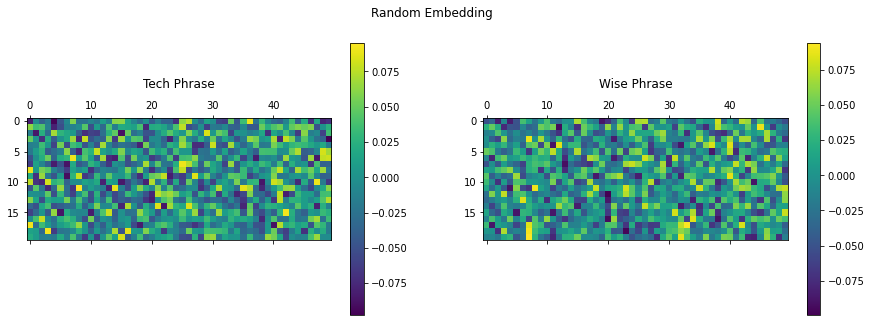

In [241]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(random_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

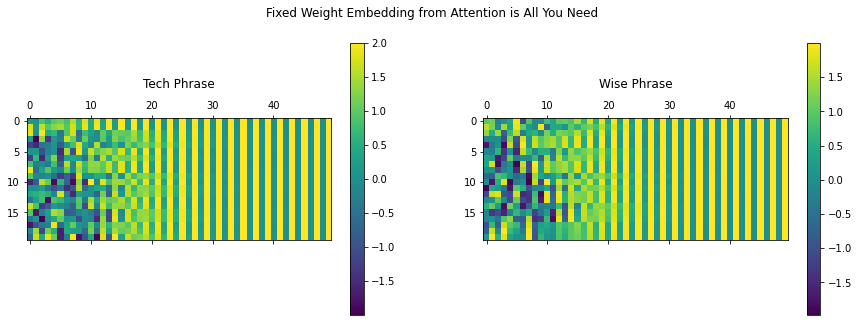

In [242]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()

In [416]:
def create_padding_mask(seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:,tf.newaxis,tf.newaxis,:]
    
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def create_masks(inputs,target):
    enc_padding_mask = create_padding_mask(inputs)
    dec_padding_mask = create_padding_mask(target)
    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
    dec_target_padding_mask = create_padding_mask(target)

    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [417]:
x=np.random.random((30,10))
y=np.random.random((30,20))

In [418]:
p,q,r=create_masks(x,y)